In [15]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606692790985107

In [2]:
from transformers import AutoModelForCausalLM

model_pt = AutoModelForCausalLM.from_pretrained(
    '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/',
    trust_remote_code=True, torch_dtype="auto", device_map='meta',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [4]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [24]:
def get_scale_by_layer(exp_path):
    data_df = get_df_from_wandb(exp_path)
    
    data_df = data_df.rename(columns={
        'wikitext2_PPL': 'wikitext2',
    })
    
    data_df = data_df[data_df['model'] == MODEL]
    data_df = data_df[['layer_idx', 'edenn_d', 'edenn_n', 'wikitext2']]
    
    data_df = data_df.dropna().copy()
    
    layer_names = []
    
    for layer_idx in range(32):
        layer_names.append(f'model.layers.{layer_idx}.self_attn.q_proj')
        layer_names.append(f'model.layers.{layer_idx}.self_attn.k_proj')
        layer_names.append(f'model.layers.{layer_idx}.self_attn.v_proj')
        layer_names.append(f'model.layers.{layer_idx}.self_attn.o_proj')
        layer_names.append(f'model.layers.{layer_idx}.mlp.gate_proj')
        layer_names.append(f'model.layers.{layer_idx}.mlp.up_proj')
        layer_names.append(f'model.layers.{layer_idx}.mlp.down_proj')

    import requests
    from ast import literal_eval
    import pandas as pd
    
    grids = literal_eval(requests.get(
        'https://gist.githubusercontent.com/BlackSamorez/c74f24a648eb8bbfbbbf83f3145ba3c7/raw/ddc3280a4861938e2e2034c29d6802817e26e799/gistfile1.txt'
    ).text)
    
    grids.append({
        'edenn_d': -1,
        'edenn_n': -1,
        'bits': 16,
        'mse': 0.0,
    })
    
    grids = pd.DataFrame(grids)
    grids['name'] = grids.apply(
        lambda row: 'edenn_d=' + str(row['edenn_d']) + ';edenn_n=' + str(row['edenn_n']),
        axis=1,
    )
    grids = grids[['bits', 'mse', 'name', 'edenn_d', 'edenn_n']]
    def get_mse(grid_tuple):
        edenn_d, edenn_n = grid_tuple
        name = f'edenn_d={edenn_d}.0;edenn_n={edenn_n}.0'
        output = grids[grids['name'] == name]['mse'].values[0]
        return output

    data_df['mse'] = data_df[['edenn_d', 'edenn_n']].apply(
        lambda row: get_mse(tuple(row.values)),
        axis=1,
    )
    
    data_df['layer'] = data_df['layer_idx'].apply(lambda idx: layer_names[idx])
    
    layers = sorted(set(data_df['layer']))
    
    from sklearn.linear_model import LinearRegression
    
    scale_by_layer = {}
    intercept_by_layer = {}
    
    for layer_idx, layer in enumerate(layers):
        to_fit = data_df[data_df['layer'] == layer]
        to_fit = to_fit[to_fit['mse'] < 0.04]
    
        slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
        
        scale_by_layer[layer] = slope.item()
        intercept_by_layer[layer] = BASE_PPL
    
    return scale_by_layer

['mlp.down_proj',
 'mlp.gate_proj',
 'mlp.up_proj',
 'self_attn.k_proj',
 'self_attn.o_proj',
 'self_attn.q_proj',
 'self_attn.v_proj']

In [82]:
!mkdir -p /tmp/galqiwi
data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')
data_df.to_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')

In [83]:
!ls -lh /tmp/galqiwi

total 22M
-rw-rw-r-- 1 galqiwi galqiwi 22M Sep 16 06:17 NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv


In [59]:
def get_scale_by_layer_no_gptq():
    data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')
    
    data_df['layer'] = data_df['layer_name']
    data_df['mse'] = data_df['relative_mse']
    
    data_df = data_df[data_df['base_model'] == MODEL]
    
    data_df = data_df[['layer', 'mse', 'wikitext2']]
    data_df = data_df.dropna().copy()

    from sklearn.linear_model import LinearRegression
    
    
    scale_by_layer = {}
    intercept_by_layer = {}
    
    for layer_idx, layer in enumerate(layers):
        to_fit = data_df[data_df['layer'] == layer]
        to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
        # to_fit = to_fit[to_fit['wikitext2'] < 5.640]
    
        slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
        
        scale_by_layer[layer] = slope.item()
        intercept_by_layer[layer] = BASE_PPL

    return scale_by_layer

In [62]:
scale_by_layer_no_gptq = get_scale_by_layer_no_gptq()

In [63]:
scale_by_layer_gptq = get_scale_by_layer('rock-and-roll/GALQIWI_EDENN_GPTQ')

layers = sorted(scale_by_layer.keys())

In [64]:
FIRST_LAYER_PREFIX = 'model.layers.0.'

suffixes = sorted(layer[len(FIRST_LAYER_PREFIX):] for layer in layers if layer.startswith(FIRST_LAYER_PREFIX))

suffixes

['mlp.down_proj',
 'mlp.gate_proj',
 'mlp.up_proj',
 'self_attn.k_proj',
 'self_attn.o_proj',
 'self_attn.q_proj',
 'self_attn.v_proj']

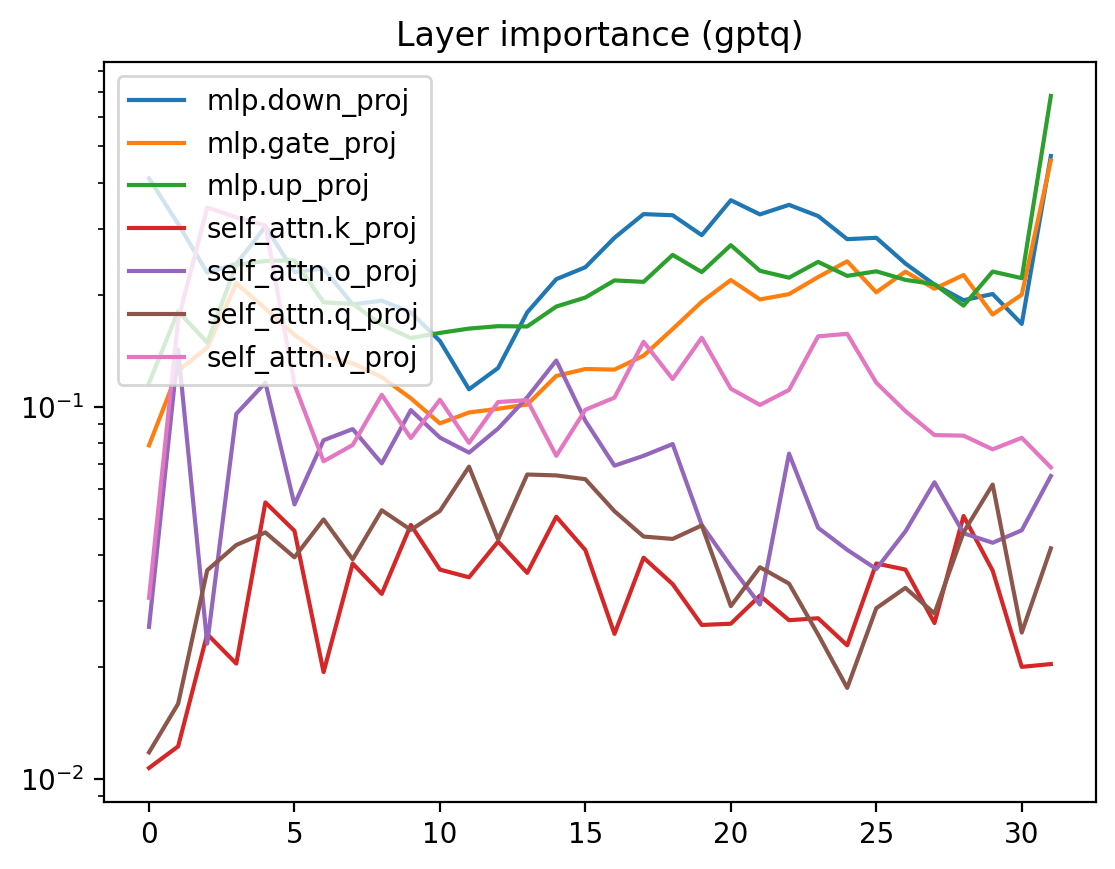

In [76]:
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

for suffix in suffixes:
    grid = list(range(0, 32))
    
    plt.plot(
        grid,
        [scale_by_layer_gptq[f'model.layers.{idx}.{suffix}'] for idx in grid],
        label=suffix,
    )

plt.title('Layer importance (gptq)')
plt.legend(loc='upper left')
plt.yscale('log')
plt.savefig('importance_gptq.png')
plt.show()

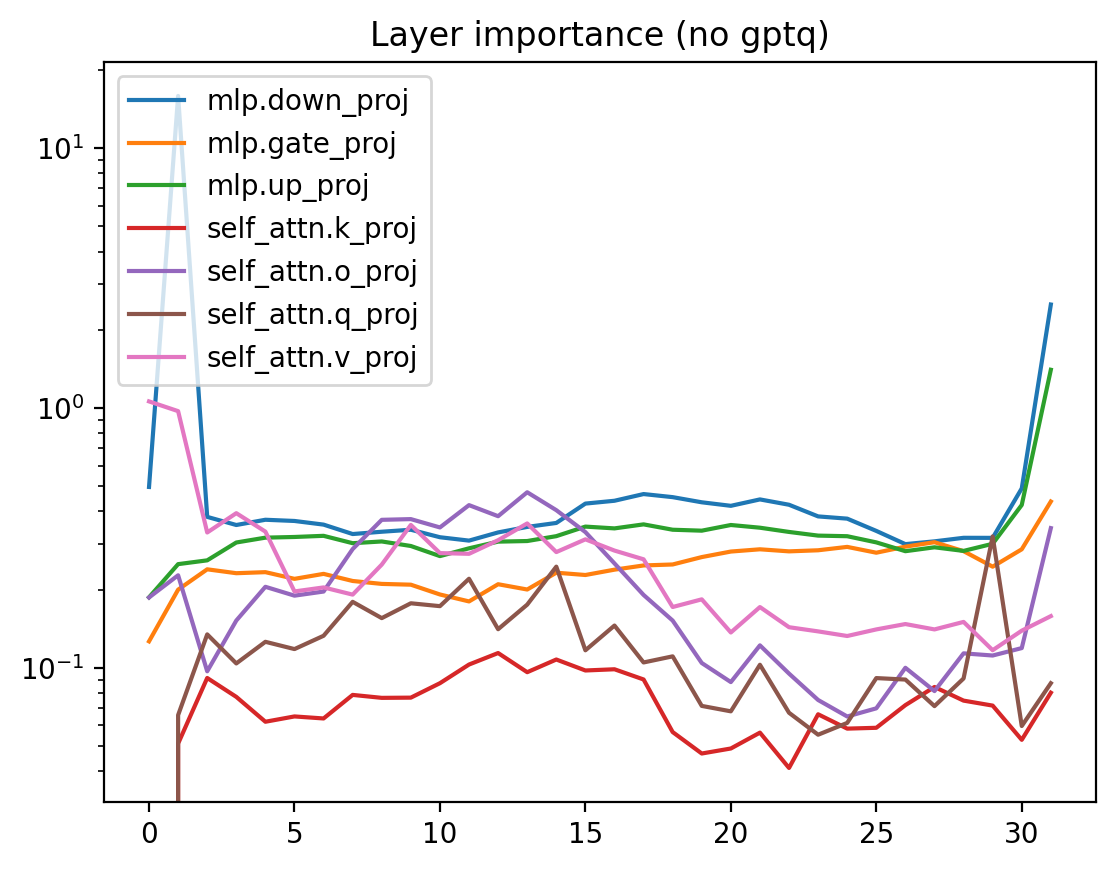

In [77]:
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

for suffix in suffixes:
    grid = list(range(0, 32))
    
    plt.plot(
        grid,
        [scale_by_layer_no_gptq[f'model.layers.{idx}.{suffix}'] for idx in grid],
        label=suffix,
    )

plt.title('Layer importance (no gptq)')
plt.legend(loc='upper left')
plt.yscale('log')
plt.savefig('importance_no_gptq.png')
plt.show()